# Question 1

This question reproduces the result of the article "The role of South Pacific atmospheric variability
in the development of different
types of ENSO"

In [1]:
# Import needed libraries.

import sys,warnings,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from netCDF4 import Dataset,num2date
from mpl_toolkits.basemap import Basemap, cm
from datetime import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.ticker import MultipleLocator
from scipy import stats
sys.path.append('/Users/allen/Documents/Python/PlotGallary')
from matplotlibconfig import basic
#configure plot
basic()
warnings.simplefilter('ignore')

In [2]:
def visualize(lon, lat, data, ylabel='', stipple=None, **figkwargs):
    """
    Args:
    ---------------
    :figkwargs - dict; {
                        'ylabel': '',
                        'cmap': 'seismic',
                        'cRange': (-1,1),
                        'title': '',
                        'extent': tuple; (llclon, llclat, urclon, urclat)
                        'projection': str; default 'npstere'
                        }
    """
    
#     ylabel= figkwargs.get('ylabel', '')
    cmapName= figkwargs.get('cmap', 'seismic')
    cRange= figkwargs.get('cRange', (-1,1,0.2))
    title= figkwargs.get('title', '')
    lllon, lllat, urlon, urlat= figkwargs.get('extent', (-240, -75, -60, 30))
    proj= figkwargs.get('projection', 'npstere')
    vmin= figkwargs.get('vmin', 0)
    vmax= figkwargs.get('vmax', 1)
    if proj!='npstere':
        rnd= False
    else: rnd=True
    
    cmin = cRange[0]; cmax = cRange[1];
    cint = cRange[2]; clevs = np.arange(cmin,cmax,cint)
    nlevs = len(clevs)-1
    
    plt.gca()
#     cmap = plt.get_cmap(name= cmapName,lut=nlevs) 
    m = Basemap(projection='cyl',
            llcrnrlat=lllat,urcrnrlat=urlat,llcrnrlon=lllon,urcrnrlon=urlon,resolution='c')
#     x,y = np.meshgrid(lon, lat)
    x,y = m(lon,lat)
    m.drawcoastlines(linewidth=3)
    m.drawmapboundary(linewidth=2)
    m.drawmeridians(range(-360, 0, 20),labels=[True,False,False,True])
    m.drawparallels(range(-90, 90, 10),labels=[True,False,False,True])
    m.fillcontinents(color='gray')
    if stipple is not None:
        m.plot(x[stipple], y[stipple],'o',color='Gold',markersize=1.5) #
    cs = m.contourf(x, y, data, cmap=cmapName, vmin=vmin, vmax=vmax)
    cbar = m.colorbar(cs,size='2%')
    cbar.ax.set_ylabel(ylabel) 
    plt.title(title,name='Arial',weight='bold',size=20);
    
    return m

def read_field(fname, years, fieldname):
    field= {}
    with Dataset(fname,'r') as nc:
        field['lon'] = nc.variables['lon'][:] - 360.
        field['lat'] = nc.variables['lat'][:]
        
        time = nc.variables['time'][:]
        timeUnits = nc.variables['time'].units

        tmp = num2date(time,timeUnits,calendar='standard')
        allDates = np.asarray([datetime(d.year,d.month,15) for d in tmp])
        itime = np.where( (allDates>=datetime(years[0],1,1)) & (allDates<datetime(years[1]+1,1,1)) )[0]

        field['date'] = allDates[itime]
        field['year'] = np.asarray([d.year for d in field['date']])
        field['month'] = np.asarray([d.month for d in field['date']])

        # Read in the data.
#         print(nc.variables)
        tmp = nc.variables[fieldname][itime,:,:] # time x lat x lon
        try: field['data'] = np.where(tmp.mask,np.nan,tmp.data)
        except: field['data'] = tmp

        # Define a land mask for your data. The mask will be NaN for all land points
        # and 1 for all ocean points.

        field['mask'] = np.where(~np.isnan(field['data'][0,:,:].squeeze()),1,np.nan)
        field['units'] = nc.variables[fieldname].units
        
    return field

In [3]:
# read in sst and slp data
years = np.array([1948,2015])

sst= read_field('sst.mon.mean.nc', years, 'sst')
slp= read_field('slp.mon.mean.nc', years, 'slp')
lon, lat= slp['lon'], slp['lat']

In [4]:
# read in wind vector data
wind= {}
uwind= Dataset('uwnd.10m.mon.mean.nc', 'r')
vwind= Dataset('vwnd.10m.mon.mean.nc', 'r')
time = uwind.variables['time'][:]
timeUnits = uwind.variables['time'].units
tmp = num2date(time,timeUnits,calendar='standard')
allDates = np.asarray([datetime(d.year,d.month,15) for d in tmp])
itime = np.where( (allDates>=datetime(years[0],1,1)) & (allDates<datetime(years[1]+1,1,1)) )[0]

wind['date']= allDates[itime]
wind['year']= np.asarray([d.year for d in wind['date']])
wind['month']= np.asarray([d.month for d in wind['date']])
wind['lon']= uwind['lon'][:] - 360.
wind['lat']= uwind['lat'][:]

tmp = uwind.variables['uwnd'][itime,:,:]
try: wind['uwind'] = np.where(tmp.mask,np.nan,tmp.data)
except: wind['uwind'] = tmp

tmp = vwind.variables['vwnd'][itime,:,:]
try: wind['vwind'] = np.where(tmp.mask,np.nan,tmp.data)
except: wind['vwind'] = tmp


## preprocessing

In this step, we are going to compute the anomalies for each field and linearly detrend.

### Anomalies

In [5]:
def computeAnomalies(data, year, month, base_period=[1981, 2010]):
    '''
    compute anomalies based on long-term monthly climatology
    
    Args:
    -----------------
    :data - numpy.ndarray - (time, lon, lat)
    :year - numpy.ndarray - (year)
    :month - numpy.ndarray - (month)
    
    Returns:
    -----------------
    :ano - numpy.ndarray - shape of (time, lon, lat)
    '''

    ano= np.zeros(data.shape)*np.nan
    
    for imon in range(1,13):
        xClimo= np.where( (year>=base_period[0]) & (year<=base_period[1]) & (month==imon) )[0]
        x= np.where(month==imon)[0]
        
        ano[x,:,:]= data[x,:,:] - np.nanmean(data[xClimo,:,:], axis=0)
        
    return ano


In [6]:
sst['ano']= computeAnomalies(sst['data'], sst['year'], sst['month'])
slp['ano']= computeAnomalies(slp['data'], slp['year'], slp['month'])
wind['u_ano']= computeAnomalies(wind['uwind'], wind['year'], wind['month'])
wind['v_ano']= computeAnomalies(wind['vwind'], wind['year'], wind['month'])

### detrend

In [7]:
def detrend(y):
    '''
    linear regression to detrend
    
    Args:
    -------------------
    :y - numpy.ndarray; target to detrend
    
    Returns:
    -------------------
    :detrend - numpy.ndarray; 
    '''
    
    t= np.arange(len(y))
    E= np.ones((t.size,2))*np.nan
    E[:,0] = t
    E[:,1] = 1
    xhat = np.linalg.inv(np.transpose(E).dot(E)).dot(E.T).dot(y)
    trend = E.dot(xhat)
    detrend= y- trend
    
    return detrend, xhat

In [8]:
T, J, I= slp['data'].shape
sst['detrend'], _= detrend(sst['ano'].reshape(T, -1, order='F'))
slp['detrend'], _= detrend(slp['ano'].reshape(T, -1, order='F'))
wind['u_detrend'], _= detrend(wind['u_ano'].reshape(T, -1, order='F'))
wind['v_detrend'], _= detrend(wind['v_ano'].reshape(T, -1, order='F'))

### 3-month running mean

In [9]:
runningMean= True

if runningMean:
    # MAM, JJA, SON, DJF
    imonth= [slice(i*3+2,(i+1)*3+2) for i in range(len(slp['month'])//3-1)]
    tmp= [np.nanmean(sst['detrend'][i], axis=0) for i in imonth]
    sst['mean']= np.stack(tmp)

    tmp= [np.nanmean(slp['detrend'][i], axis=0) for i in imonth]
    slp['mean']= np.stack(tmp)

    tmp= [np.nanmean(wind['u_detrend'][i], axis=0) for i in imonth]
    wind['u_mean']= np.stack(tmp)

    tmp= [np.nanmean(wind['v_detrend'][i], axis=0) for i in imonth]
    wind['v_mean']= np.stack(tmp)
    field='mean'
else:
    field= 'detrend'

### Choose domain

In [10]:
ilon= np.where((lon>=-160) & (lon<=-70))[0]
ilat= np.where((lat>=-45) & (lat<=-10))[0]

lat= lat[ilat]
lon= lon[ilon]

### remove NAN values

In [11]:
T= slp[field].shape[0]
# ==============cosine weighted============
# slpa= slp[field].reshape((T, I, J), order='F')[:,ilon, :][:, :, ilat]
# weights = np.cos(np.deg2rad(lat))**.5
# weightedSLPa = (slpa*weights).transpose(0,2,1).reshape(T,-1, order='F')
# _, cols= np.where(np.isnan(weightedSLPa))

# A = np.delete(weightedSLPa, cols, axis=1)
#==============non-cosine weigted=========
slpa= slp[field].reshape((T, J, I), order='F')[:,ilat, :][:, :, ilon].reshape(T,-1,order='F')
_, cols= np.where(np.isnan(slpa))
A= np.delete(slpa, cols, axis=1)


## EOF analysis

### Singular value decomposition

In [12]:
U, S, V= np.linalg.svd(A)

PCs = U
eigval = S**2/A.shape[1] 

## Present results

In [13]:
stdPCs = (PCs[:,0]- PCs[:,0].mean())/PCs[:,0].std()

# regressPatterns = sst[field].reshape(T,-1,order='F').T.dot(stdPCs)/T
regressSST= stdPCs.T.dot(sst[field])/T
regressSLP= stdPCs.T.dot(slp[field])/T
regressWU= stdPCs.T.dot(wind['u_'+field])/T
regressWV= stdPCs.T.dot(wind['v_'+field])/T

varExp = eigval/(eigval).sum()

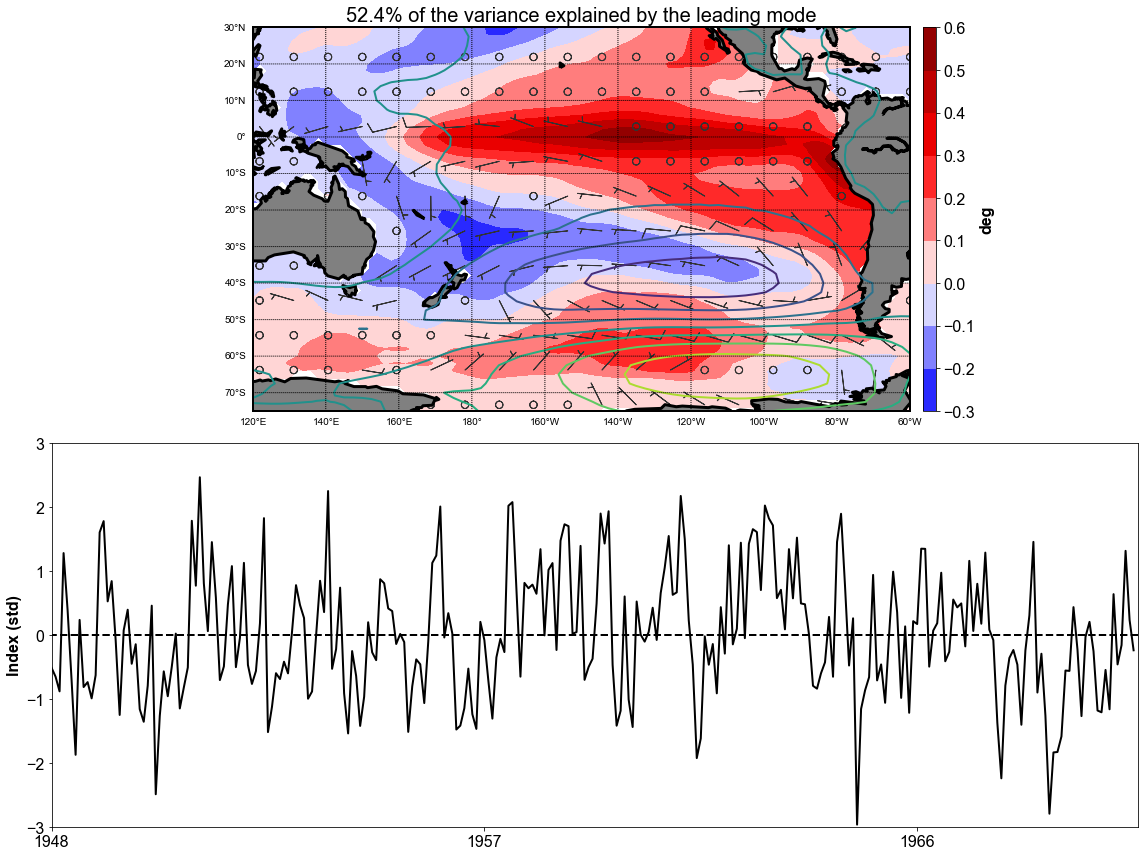

In [14]:
lon= sst['lon']
lat= sst['lat']
x,y= np.meshgrid(lon, lat)
x_slp, y_slp= np.meshgrid(slp['lon'], slp['lat'])
x_wind, y_wind= np.meshgrid(wind['lon'], wind['lat'])
fig= plt.figure(figsize=(16,12))
ax= fig.add_subplot(211)
m= visualize(x, y, regressSST.reshape(len(lat),len(lon),order='F'), ylabel='deg', vmin=-0.6, vmax=0.6)
m.contour(x_slp,y_slp,regressSLP.reshape(x_slp.shape[0], y_slp.shape[1],order='F'))
m.barbs(x_wind[::5,::5], y_wind[::5,::5], regressWU.reshape(x_wind.shape[0], y_wind.shape[1],order='F')[::5,::5]*10,
        regressWV.reshape(x_wind.shape[0], y_wind.shape[1],order='F')[::5,::5]*10, pivot='tip', barbcolor='#333333')
ax.set_title('%.1f%s of the variance explained by the leading mode'%(varExp[0]*100, str('%')), fontsize=20)
ax= fig.add_subplot(212)
ax.plot(stdPCs, color='k')
ax.set_xticks(np.arange(len(stdPCs))[::108])
ax.set_xticklabels( list(sst['year'])[::108])
ax.set_ylabel('Index (std)')
ax.set_ylim([-3,3])
ax.hlines(0, len(stdPCs), 0, 'k', linestyle='--')
ax.set_xlim([0, len(stdPCs)])
plt.tight_layout();

In [17]:
sst['date'][::108]

array([datetime.datetime(1948, 1, 15, 0, 0),
       datetime.datetime(1957, 1, 15, 0, 0),
       datetime.datetime(1966, 1, 15, 0, 0),
       datetime.datetime(1975, 1, 15, 0, 0),
       datetime.datetime(1984, 1, 15, 0, 0),
       datetime.datetime(1993, 1, 15, 0, 0),
       datetime.datetime(2002, 1, 15, 0, 0),
       datetime.datetime(2011, 1, 15, 0, 0)], dtype=object)

In [15]:
np.savetxt('SPO.txt', stdPCs)

Fig.1 Regression of SLPa (contour, hPa), SSTa (shading, deg) and 10 m wind anomalies (vector, m/s) onto the standardized PC1 time series of monthly mean South Pacific SLPa (i.e., the SPO index). 30.8% of the variance is explained by the leading mode.

__Summary:__

In this exercise, I am trying to reproduce the result of the paper "The role of South Pacific atmospheric variability in the development of different types of ENSO" which identifies a new mode of variability: the South Pacific Oscillation (SPO). Three datasets are used in this exercise: sea surface temperature, sea level pressure, and wind vector in two dimensions. The goal is to identify the variability of sea level pressure and then regress these three fields onto the identified PC time series. To construct this relation, the three datasets are first used to compute their monthly anomalies in the base period and linearly detrended. Possibly, three-month mean is applied. After the preprocessing, the SVD analysis is conducted and to find PC time series. The last part is to project three fields onto this PC time series and get the result as above.

I failed to reproduce the exact result as the paper suggested and have been stuck there for quite a long time. I would appreciate if the wrong steps are pointed out. Also, I have tried three-month running mean but the results are not right. I don't think something goes wrong with my EOF analysis because I validated it with some open source packages online. Probably something goes wrong with my preprocessing step.

# Question 2

## Data preparation

In [25]:
# read in data
years = np.array([1950,2010])

gph= read_field('GPH500.nc', years, 'hgt')
sst= read_field('sst.mon.mean.nc', years, 'sst')

In [26]:
#choose domain
ilon= np.where((sst['lon']>=-280) & (sst['lon']<=-65))[0]
ilat= np.where((sst['lat']>=15) & (sst['lat']<=70))[0]
sst['lon']= sst['lon'][ilon]
sst['lat']= sst['lat'][ilat]
sst['subset']= sst['data'][:, ilat, :][:,:,ilon]

ilon= np.where((gph['lon']>=-280) & (gph['lon']<=-65))[0]
ilat= np.where((gph['lat']>=15) & (gph['lat']<=70))[0]
gph['lon']= gph['lon'][ilon]
gph['lat']= gph['lat'][ilat]
gph['subset']= gph['data'][:, ilat, :][:,:,ilon]

### Remove seasonal cycle

In [27]:
sst['ano']= computeAnomalies(sst['subset'], sst['year'], sst['month'], base_period=[1981,2010])
gph['ano']= computeAnomalies(gph['subset'], gph['year'], gph['month'], base_period=[1981,2010])

### Detrend

In [28]:
T,I,J= sst['data'].shape
sst['detrend'],_= detrend(sst['ano'].reshape(T,-1,order='F'))
gph['detrend'],_= detrend(gph['ano'].reshape(T,-1,order='F'))

### weight data

In [29]:
#weighted and remove NAN values
#=============================================
T, I, J= sst['subset'].shape
ssta= sst['detrend'].reshape((T, J, I), order='F')
weights = np.cos(np.deg2rad(sst['lat']))**.5
weightedSSTa = (ssta*weights).transpose(0,2,1).reshape(T,-1, order='F')
_, cols= np.where(np.isnan(weightedSSTa))

X = np.delete(weightedSSTa, cols, axis=1)

#==============================================
T, I, J= gph['subset'].shape

gpha= gph['detrend'].reshape((T, J, I), order='F')
weights = np.cos(np.deg2rad(gph['lat']))**.5
weightedGPHa = (gpha*weights).transpose(0,2,1).reshape(T,-1, order='F')
_, cols= np.where(np.isnan(weightedGPHa))

Y = np.delete(weightedGPHa, cols, axis=1)

## Calculate RMSC metric

In [30]:
def RMSC(X,Y):
    '''return root-mean-squared-covariance metric'''
    T= X.shape[0]
    norm= np.nanmean((np.nansum(X,axis=1)* np.nansum(Y,axis=1)))**2
    denorm= np.nansum(X**2,axis=1).mean()* np.nansum(Y**2, axis=1).mean()
    
    return (norm/denorm)**.5

In [31]:
print('the root-mean-square covariance is: %.2f'%RMSC(X,Y))

the root-mean-square covariance is: 29.53


According to the result, since the RMSC is way above 0.1, we are confident to say the two fields are well correlated enough.

## EOF analysis of covariability

In [32]:
C= X.T.dot(Y)/T

U, S, V= np.linalg.svd(C)

SCF = S**2/(S**2).sum()

EC_x= X.dot(U)
EC_y= Y.dot(V.T)

#standardize EC
EC_x= (EC_x - EC_x.mean(axis=0) )/ EC_x.std(axis=0)
EC_y= (EC_y - EC_y.mean(axis=0) )/ EC_y.std(axis=0)

In [33]:
#homogenious regression
Xparttern= EC_x.T.dot(ssta.reshape(T,-1, order='F'))/T
Yparttern= EC_y.T.dot(gpha.reshape(T,-1, order='F'))/T

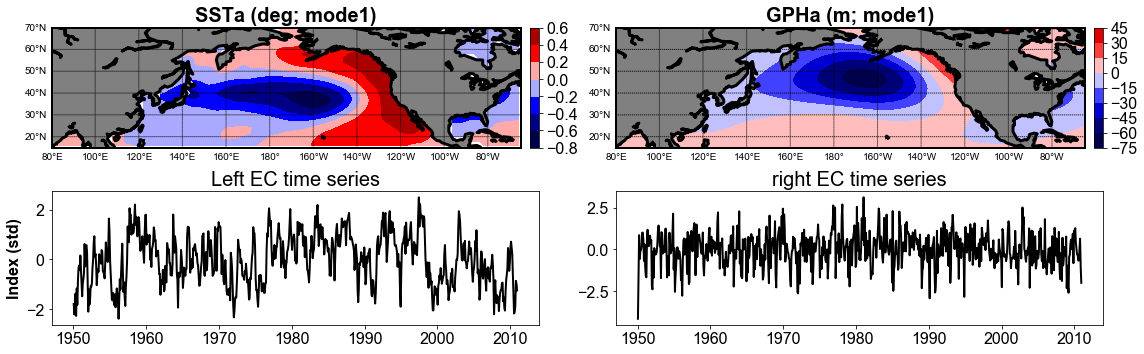

In [46]:
x_sst,y_sst= np.meshgrid(sst['lon'], sst['lat'])
x_gph,y_gph= np.meshgrid(gph['lon'], gph['lat'])
fig= plt.figure(figsize=(16,5))
ax= fig.add_subplot(221)
m= visualize(x_sst, y_sst, Xparttern[0].reshape(x_sst.shape[0], x_sst.shape[1], order='F'),
             extent=(-280,15,-65,70), label='deg',cmap='seismic', cRange=(-0.6,0.6,0.2), vmin=-0.6, vmax=0.6)
ax.set_title('SSTa (deg; mode1)', weight='bold')
ax=fig.add_subplot(223)
ax.plot(sst['date'], EC_x[:,0], 'k')

# ax.set_xticks(np.arange(T))
# ax.set_xticklabels()
ax.set_title('Left EC time series')
ax.set_ylabel('Index (std)')
ax= fig.add_subplot(222)
m =visualize(x_gph, y_gph, Yparttern[0].reshape(x_gph.shape[0], x_gph.shape[1], order='F'),
             extent=(-280,15,-65,70), label='m',cmap='seismic', cRange=(-60,60,10),vmin=-60, vmax=60)
ax.set_title('GPHa (m; mode1)', weight='bold')
ax=fig.add_subplot(224)
ax.plot(gph['date'], EC_y[:,0], 'k')
ax.set_title('right EC time series');

Fig.2 Homogeneous regression maps of SSTa onto left expansion coefficient time series (mode 1) in the left; GPHa onto right expandion coefficient time series (mode 1).The squared covariance function (SCF) is 55.9% for the leading mode.

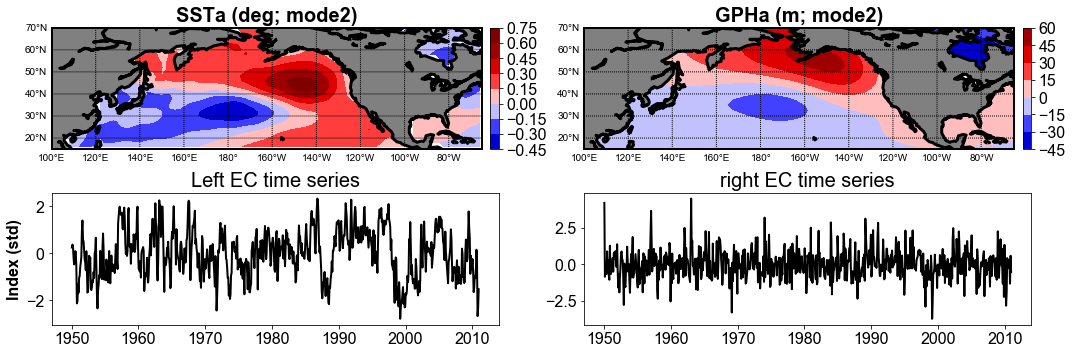

In [48]:
x_sst,y_sst= np.meshgrid(sst['lon'], sst['lat'])
x_gph,y_gph= np.meshgrid(gph['lon'], gph['lat'])
fig= plt.figure(figsize=(15,5))
ax= fig.add_subplot(221)
m= visualize(x_sst, y_sst, Xparttern[1].reshape(x_sst.shape[0], x_sst.shape[1], order='F'),
             extent=(-260,15,-65,70),cmap='seismic', cRange=(-0.6,0.6,0.2), vmin=-0.6, vmax=0.6)
ax.set_title('SSTa (deg; mode2)', weight='bold')
ax=fig.add_subplot(223)
ax.plot(sst['date'], EC_x[:,1], 'k')
# ax.set_xticks(np.arange(T))
# ax.set_xticklabels()
ax.set_title('Left EC time series')
ax.set_ylabel('Index (std)')
ax= fig.add_subplot(222)
m =visualize(x_gph, y_gph, Yparttern[1].reshape(x_gph.shape[0], x_gph.shape[1], order='F'),
             extent=(-260,15,-65,70),cmap='seismic', cRange=(-60,60,10),vmin=-60, vmax=60)
ax.set_title('GPHa (m; mode2)', weight='bold')
ax=fig.add_subplot(224)
ax.plot(gph['date'], EC_y[:,1], 'k')
ax.set_title('right EC time series');

Fig.3 Homogeneous regression maps of SSTa onto left expansion coefficient time series (mode 2) in the left; GPHa onto right expandion coefficient time series (mode 2).The squared covariance function (SCF) is 18.6% for the leading mode.

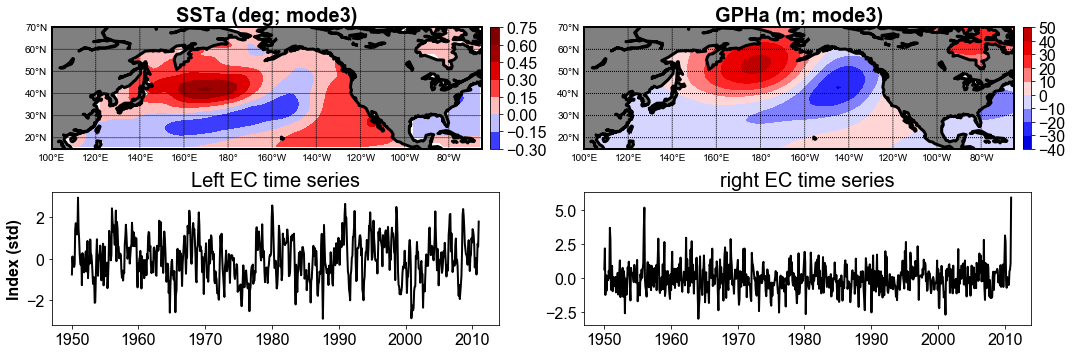

In [49]:
x_sst,y_sst= np.meshgrid(sst['lon'], sst['lat'])
x_gph,y_gph= np.meshgrid(gph['lon'], gph['lat'])
fig= plt.figure(figsize=(15,5))
ax= fig.add_subplot(221)
m= visualize(x_sst, y_sst, Xparttern[2].reshape(x_sst.shape[0], x_sst.shape[1], order='F'),
             extent=(-260,15,-65,70), cRange=(-0.6,0.6,0.2), vmin=-0.6, vmax=0.6)
ax.set_title('SSTa (deg; mode3)', weight='bold')
ax=fig.add_subplot(223)
ax.plot(sst['date'], EC_x[:,2], 'k')
# ax.set_xticks(np.arange(T))
# ax.set_xticklabels()
ax.set_title('Left EC time series')
ax.set_ylabel('Index (std)')
ax= fig.add_subplot(222)
m =visualize(x_gph, y_gph, Yparttern[2].reshape(x_gph.shape[0], x_gph.shape[1], order='F'),
             extent=(-260,15,-65,70), cRange=(-60,60,10),vmin=-60, vmax=60)
ax.set_title('GPHa (m; mode3)', weight='bold')
ax=fig.add_subplot(224)
ax.plot(gph['date'], EC_y[:,2], 'k')
ax.set_title('right EC time series');

Fig.4 Homogeneous regression maps of SSTa onto left expansion coefficient time series (mode 3) in the left; GPHa onto right expandion coefficient time series (mode 3).The squared covariance function (SCF) is 6.7% for the leading mode.

__Summary__:

First of all, the RMSC indicates the two fieds have high covariability in North Pacific, and the result of EOF analysis further corraborates this point. 55.9% of the total variance is explained by the first mode of corresponding eigenvectors from which the low GPHa centered over the North Pacific ocean with correspondence to low SSTa. The second and third mode also highlight this correspondence bewteen GPHa and SSTa.

The left expansion coefficient time series have sort of periodicity inside in general and can be further quantitatively described by the spectrum analysis. Because of this, probably we can use this characteristic to do forecast of SST and associate it with GPH.